In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy 
import pygmsh

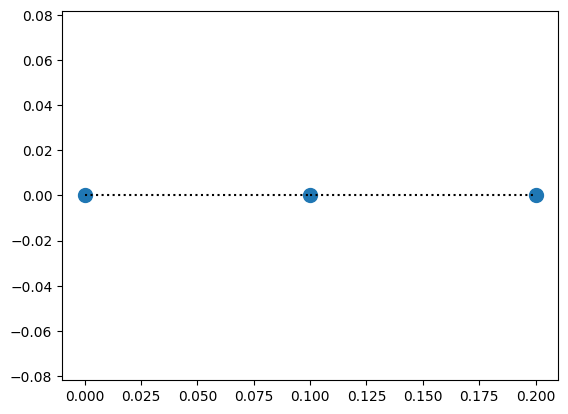

In [2]:
import matplotlib.pyplot as plt
#
plt.axis('equal')
edges = [[0, 1], [1, 2] ]
pts = [[.0, .0], [.1, .0], [.2, .0]]
#
plt.plot(np.array(pts)[:, 0], np.array(pts)[:, 1], 'o', markersize=10)
for i, j in edges:
    plt.plot(np.array(pts)[[i, j], 0], np.array(pts)[[i, j], 1], 'k:')
plt.show()

In [3]:
# 1.1
m, eta = 1E-2, 0.2
kij = 1E5
cij = 2 * eta * np.sqrt(kij * m)
#
pts = np.array(pts)
edges = np.array(edges)
# length of the spring, cos(theta), sin(theta)
Kij = np.zeros((len(pts)*2, len(pts)*2))
Cij = np.zeros((len(pts)*2, len(pts)*2))
Mij = np.eye(len(pts)*2) * m
# Mij = np.zeros((len(pts)*2, len(pts)*2))
for p, q in edges:
    l = np.linalg.norm(pts[p] - pts[q])
    c = (pts[p, 0] - pts[q, 0]) / l
    s = (pts[p, 1] - pts[q, 1]) / l
    # print(f"l_{n} = {l:.2f}, c_{n} = {c:.2f}, s_{n} = {s:.2f}")
    A = np.array([  [c**2, c * s],
                    [c * s, s**2]])
#
    Kij[2*p:(2*p+2), 2*p:(2*p+2)] += +A * kij
    Kij[2*q:(2*q+2), 2*q:(2*q+2)] += +A * kij
    Kij[2*p:(2*p+2), 2*q:(2*q+2)] += -A * kij
    Kij[2*q:(2*q+2), 2*p:(2*p+2)] += -A * kij
#
    Cij[2*p:(2*p+2), 2*p:(2*p+2)] += +A * cij
    Cij[2*q:(2*q+2), 2*q:(2*q+2)] += +A * cij
    Cij[2*p:(2*p+2), 2*q:(2*q+2)] += -A * cij
    Cij[2*q:(2*q+2), 2*p:(2*p+2)] += -A * cij
    # Mij[2*n:(2*n+4), 2*n:(2*n+4)] = np.array([[1, 0, 0, 0],
    #                                             [0, 1, 0, 0],
    #                                             [0, 0, 1, 0],
    #                                             [0, 0, 0, 1]]) * m
# 
display(pd.DataFrame(Kij))
display(pd.DataFrame(Cij))
display(pd.DataFrame(Mij))

,0,1,2,3,4,5
0,100000.0,0.0,-100000.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,-100000.0,0.0,200000.0,0.0,-100000.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,-100000.0,0.0,100000.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5
0,12.649111,0.0,-12.649111,0.0,0.000000,0.0
1,0.000000,0.0,0.000000,0.0,0.000000,0.0
2,-12.649111,0.0,25.298221,0.0,-12.649111,0.0
3,0.000000,0.0,0.000000,0.0,0.000000,0.0
4,0.000000,0.0,-12.649111,0.0,12.649111,0.0
5,0.000000,0.0,0.000000,0.0,0.000000,0.0


,0,1,2,3,4,5
0,0.01,0.00,0.00,0.00,0.00,0.00
1,0.00,0.01,0.00,0.00,0.00,0.00
2,0.00,0.00,0.01,0.00,0.00,0.00
3,0.00,0.00,0.00,0.01,0.00,0.00
4,0.00,0.00,0.00,0.00,0.01,0.00
5,0.00,0.00,0.00,0.00,0.00,0.01


In [4]:
#
def extU(t, nodes, u, freq):
    #
    __u = np.array(u)
    __freq = np.array(freq)
    #
    __Ut = np.zeros((len(pts)*2, ))
    __Ut[nodes] = __u[:, :, 0] @ np.sin(2*np.pi*__freq*t) 
    __Ut[nodes] += __u[:, :, 1] @ np.cos(2*np.pi*__freq*t)
    # 
    __Vt = np.zeros((len(pts)*2, ))
    __Vt[nodes] = __u[:, :, 0] * 2*np.pi*__freq @ np.cos(2*np.pi*__freq*t)
    __Vt[nodes] += -__u[:, :, 1] * 2*np.pi*__freq @ np.sin(2*np.pi*__freq*t)
    #
    __At = np.zeros((len(pts)*2, ))
    __At[nodes] = -__u[:, :, 0] * (2*np.pi*__freq)**2 @ np.sin(2*np.pi*__freq*t)
    __At[nodes] += -__u[:, :, 1] * (2*np.pi*__freq)**2 @ np.cos(2*np.pi*__freq*t)
    return __Ut, __Vt, __At

    
def extF(t, nodes, f, freq):
    #
    __f = np.array(f)
    __freq = np.array(freq)
    #
    __Ft = np.zeros((len(pts)*2, ))
    __Ft[nodes] = __f[:, :, 0] @ np.sin(2*np.pi*__freq*t)
    __Ft[nodes] += __f[:, :, 1] @ np.cos(2*np.pi*__freq*t)
    return __Ft
    
    
def extVolForce(t,  V, freq, G):
        # Calculate the direction of the edges
        vec = pts[edges[:, 1], :] - pts[edges[:, 0], :]
        norm_vec = np.linalg.norm(vec, axis=1)[:, np.newaxis]
        vec /= norm_vec
        # Create an empty array to store the voltage force
        voltage_force = np.empty((edges.shape[0], 2))
        # Assign the voltage force to the array
        #
        __V = np.array(V)
        __freq = np.array(freq)
        Vt = __V[:, :, 0] @ np.sin(2*np.pi*__freq*t)
        Vt += __V[:, :, 1] @ np.cos(2*np.pi*__freq*t)
        #
        voltage_force[:, 0] = vec[:, 0] * (Vt * G)
        voltage_force[:, 1] = vec[:, 1] * (Vt * G)
        # Add the voltage force to the external force
        extForces = np.zeros((len(pts), 2))
        for n, e in enumerate(edges):
            extForces[e[0], :] -= voltage_force[n, :]
            extForces[e[1], :] += voltage_force[n, :]
        return extForces.flatten()

In [5]:
Freq = [2]
#
UNodes = [0, 1, -1]
U = np.zeros((len(UNodes), len(Freq), 2))
FNodes = [0, 1, -1]
F = np.zeros((len(FNodes), len(Freq), 2))
#
G = 1E-3
V = np.zeros((len(edges), len(Freq), 2))
V[-1] = [[10, 10]]
print(edges[-1])
#
node_state = np.array([True] * len(pts)*2)
node_state[UNodes] = False

[1 2]


In [6]:
_Ft = np.zeros((len(pts)*2, ))
_Ft = extF(0, FNodes, F, Freq)
_Ft += extVolForce(0, V, Freq, G)
print(_Ft)

[ 0.    0.   -0.01  0.    0.01  0.  ]


In [7]:
def derivation(t, y, K, C, M):
    #
    _Ft = np.zeros((len(pts)*2, ))
    _Ft = extF(t, FNodes, F, Freq)
    _Ft += extVolForce(t, V, Freq, G)
    # _Ft = extF(t, Nodes, [[[0, 0], [0, 0]], [[0, 0], [0, 0]], [[2, 0], [0, 0]]], [2, 3])
    _U, _V, _A = extU(t, UNodes, U, Freq)
    _Ft -= np.dot(K, _U) + np.dot(C, _V) + np.dot(M, _A)
    #
    #
    Ftff = _Ft[node_state]
    Kff = Kij[node_state][:, node_state]
    Cff = Cij[node_state][:, node_state]
    Mff = Mij[node_state][:, node_state]
    #
    u = y.reshape(2, -1)[0]
    du = y.reshape(2, -1)[1]
    #
    ddu = np.linalg.solve(Mff, Ftff-np.dot(Cff, du) - np.dot(Kff, u))
    
    return np.concatenate([du, ddu])


In [11]:
from scipy.integrate import solve_ivp
y0 = np.zeros(((len(pts)*2-len(UNodes))*2))
sol = solve_ivp(lambda __t, __y: derivation(__t, __y, Kij, Cij, Mij), [0, 3], y0=y0, t_eval=np.linspace(0, 3, 1000))
# Displacement
disp = np.zeros((len(pts)*2, 2, len(sol.t)))
disp[node_state, 0] = sol.y[:len(sol.y)//2] 
# disp[0,~node_state,:]
disp[node_state, 1] = sol.y[-len(sol.y)//2:]

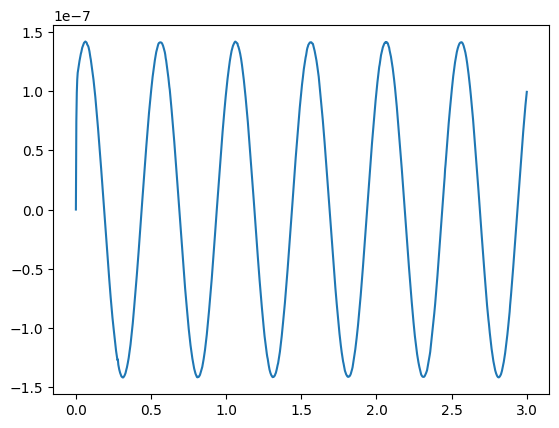

In [9]:
import matplotlib.pyplot as plt

plt.plot(sol.t, disp[-2, 0])
plt.show()

In [10]:
# """
# use mph package to create a transient model for the truss structure
# """
# import mph
# 
# # create a COMSOL client
# client = mph.start()
# pymodel = client.create("Model")
# model = pymodel.java  # create a COMSOL model
# 
# # create a 2D geometry
# model.modelNode().create("comp1")
# model.geom().create("geom1", 2)
# model.component("comp1").mesh().create("mesh1")
# 
# # Points and lines
# for n, p in enumerate(pts):
#     model.geom("geom1").feature().create(f"pt{n+1}", "Point")
#     model.geom("geom1").feature(f"pt{n+1}").setIndex("p", p[0], 0)
#     model.geom("geom1").feature(f"pt{n+1}").setIndex("p", p[1], 1)
#     model.geom("geom1").run(f"pt{n+1}")
# 
# for m, (i, j) in enumerate(edges):
#     model.geom("geom1").feature().create(f"ls{m+1}", "LineSegment")
#     model.geom("geom1").feature(f"ls{m+1}").selection("vertex1").set(f"pt{i+1}", 1)
#     model.geom("geom1").feature(f"ls{m+1}").selection("vertex2").set(f"pt{j+1}", 1)
#     model.geom("geom1").run(f"ls{m+1}")
# #
# model.geom("geom1").run("fin")
# 
# #
# model.component("comp1").physics().create("truss", "Truss", "geom1")
# model.component("comp1").physics("truss").create("spdm1", "SpringDamperMaterial", 1)
# # Set with the line labels
# 
# 
# # Save the model
# model.save("truss.mph")
